In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%tensorflow_version 1.x
import tensorflow as tf 
tf.__version__
import numpy as np
import pandas as pd
import os
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model

In [ ]:
data_path = "drive/MyDrive/dataset/spoc-train.tsv"
data = pd.read_csv(data_path, sep="\t")
data.head()

,text,code,workerid,probid,subid,line,indent
0,"in the function gcd(a,b=integers)","int gcd(int a, int b) {",38,13A,41120785,0,0
1,"if b=1 return a, else call function gcd(b, a%b)","return !b ? a : gcd(b, a % b);",38,13A,41120785,1,1
2,NaN,},38,13A,41120785,2,0
3,NaN,int main() {,38,13A,41120785,3,0
4,"n , nn, ans = integers with ans =0","int n, nn, ans = 0;",38,13A,41120785,4,1


In [ ]:
data = data.drop(['workerid', 'probid', 'subid', 'line', 'indent'], axis=1)
data.head()

,text,code
0,"in the function gcd(a,b=integers)","int gcd(int a, int b) {"
1,"if b=1 return a, else call function gcd(b, a%b)","return !b ? a : gcd(b, a % b);"
2,NaN,}
3,NaN,int main() {
4,"n , nn, ans = integers with ans =0","int n, nn, ans = 0;"


In [ ]:
pd.isnull(data).sum()

text    77629
code        0
dtype: int64

In [ ]:
# Dropping rows with NaN values 
df = data.dropna(axis=0, how="any")
df.head()
lines = df 

In [ ]:
lines.head(20)

,text,code
0,"in the function gcd(a,b=integers)","int gcd(int a, int b) {"
1,"if b=1 return a, else call function gcd(b, a%b)","return !b ? a : gcd(b, a % b);"
4,"n , nn, ans = integers with ans =0","int n, nn, ans = 0;"
5,Read n,cin >> n;
6,for i=2 to n-1 execute,for (int i = 2; i <= n - 1; ++i) {
7,set nn to n,nn = n;
8,"while nn is not equal to 0, set ans to ans + n...","while (nn) ans += nn % i, nn /= i;"
10,"set o to gcd(ans, n-2)","int o = gcd(ans, n - 2);"
11,"print out ans/o ""/"" (n-2)/o","cout << ans / o << ""/"" << (n - 2) / o << ""\n"";"
14,function gcd with integer arguments a and b,"int gcd(int a, int b) {"


In [ ]:
lines.shape

(216225, 2)

In [ ]:
# Picking random sample of length 
lines=lines.sample(n=200000,random_state=42)
lines.shape

(200000, 2)

In [ ]:
# Lowercase all characters
lines['text']=lines['text'].apply(lambda x: x.lower())
lines['code']=lines['code'].apply(lambda x: x.lower())

In [ ]:
# Remove extra spaces
lines['text']=lines['text'].apply(lambda x: x.strip())
lines['code']=lines['code'].apply(lambda x: x.strip())
# Remove semicolon
lines['text']=lines['text'].apply(lambda x: re.sub(";", " ", x))
lines['code']=lines['code'].apply(lambda x: re.sub(";", " ", x))

# Remove brackets 
lines['text']=lines['text'].apply(lambda x: re.sub("[\[({})\]]", " ", x))
lines['code']=lines['code'].apply(lambda x: re.sub("[\[({})\]]", " ", x))

lines['text']=lines['text'].apply(lambda x: re.sub(" +", " ", x))
lines['code']=lines['code'].apply(lambda x: re.sub(" +", " ", x))

In [ ]:
# Add start and end tokens to target sequences
lines['code'] = lines['code'].apply(lambda x : 'START_ '+ x + ' _END')

In [ ]:
lines.head()

,text,code
142886,else,START_ else _END
35020,create long longs a and b,"START_ long long a, b _END"
285204,increment ans by n / 10,START_ ans += n / 10 _END
173121,change s to s + f2 - f1,START_ s = s + f2 - f1 _END
46965,t= in array of length 50,START_ int t 50 _END


In [ ]:
# Fetching all the distinct words in text and code columns 
text_words = set()
for text_word in lines['text']:
    for word in text_word.split():
        if word not in text_words:
            text_words.add(word)
    
code_words = set()
for code_word in lines['code']:
    for word in code_word.split():
        if word not in code_words:
            code_words.add(word)

In [ ]:
len(text_words), len(code_words)

(14819, 11160)

In [ ]:
lines['text_length']=lines['text'].apply(lambda x:len(x.split(" ")))
lines['code_length']=lines['code'].apply(lambda x:len(x.split(" ")))

In [ ]:
lines.head()

,text,code,text_length,code_length
142886,else,START_ else _END,1,5
35020,create long longs a and b,"START_ long long a, b _END",6,7
285204,increment ans by n / 10,START_ ans += n / 10 _END,6,8
173121,change s to s + f2 - f1,START_ s = s + f2 - f1 _END,8,10
46965,t= in array of length 50,START_ int t 50 _END,6,6


In [ ]:
lines[lines['text_length']<=20].shape, lines[lines['code_length']<=20].shape

((196971, 4), (196806, 4))

In [ ]:
lines=lines[lines['text_length']<=20]
lines=lines[lines['code_length']<=20]

In [ ]:
lines.shape

(195631, 4)

In [ ]:
print("maximum length of codes ",max(lines['code_length']))
print("maximum length of texts ",max(lines['text_length']))

maximum length of codes  20
maximum length of texts  20


In [ ]:
max_length_src=max(lines['text_length'])
max_length_tar=max(lines['code_length'])

In [ ]:
input_words = sorted(list(text_words))
target_words = sorted(list(code_words))
num_encoder_tokens = len(text_words)
num_decoder_tokens = len(code_words)
num_encoder_tokens, num_decoder_tokens

(14819, 11160)

In [ ]:
num_decoder_tokens += 1 #for zero padding

In [ ]:
# Indexing all the tokens for all the codes and texts 
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [ ]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [ ]:
lines = shuffle(lines)
lines.head(10)

,text,code,text_length,code_length
258081,"declare integers a = size of a, b = size of b","START_ int a = a.size , b = b.size _END",12,11
191341,print a + b and a newline,START_ cout << a + b << endl _END,7,10
209993,print sum print newline,START_ cout << sum << endl _END,4,8
203040,increment i by 1,START_ i++ _END,4,4
149603,"declare integers x, cnt = 0","START_ int x, cnt = 0 _END",6,8
113976,return numops,START_ return numops _END,2,5
153798,set f 1 to 1,START_ f 1 = 1 _END,5,7
292590,c=0,START_ c = 0 _END,1,6
264919,read t,START_ cin >> t _END,2,6
201844,for i=0 to n exclusive while read a i,START_ for int i = 0 i < n && cin >> a i i++ ...,10,17


In [ ]:
# Splitting into training and test set  
X, y = lines['text'], lines['code']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=42)
X_train.shape, X_test.shape

((156504,), (39127,))

In [ ]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            # one hot encoding 
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] 
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] 
                    if t>0:
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)        # yielding one hot encoded data 

### Encoder-Decoder Architecture

In [ ]:
latent_dim=300

In [ ]:
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)

encoder_lstm = LSTM(latent_dim, return_state=True)      
# return_state is set to True so that the last layer of encoder returns the output to the first layer of decoder  

encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]     # hidden state and cell state 

In [ ]:
# Decoder
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
# return_sequences and return_states are kept true so that the output of decoder states are captured 

decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, None, 300)    4445700     input_5[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, None, 300)    3348300     input_6[0][0]                    
____________________________________________________________________________________________

In [ ]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 256
epochs = 50

In [ ]:
history = model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)



Epoch 1/50
611/611 [==============================] - 287s 469ms/step - loss: 0.8219 - val_loss: 0.5224
Epoch 2/50
611/611 [==============================] - 281s 460ms/step - loss: 0.4165 - val_loss: 0.3525
Epoch 3/50
611/611 [==============================] - 283s 463ms/step - loss: 0.2997 - val_loss: 0.2833
Epoch 4/50
611/611 [==============================] - 279s 457ms/step - loss: 0.2416 - val_loss: 0.2488
Epoch 5/50
611/611 [==============================] - 280s 459ms/step - loss: 0.2055 - val_loss: 0.2297
Epoch 6/50
611/611 [==============================] - 280s 458ms/step - loss: 0.1803 - val_loss: 0.2163
Epoch 7/50
611/611 [==============================] - 279s 456ms/step - loss: 0.1612 - val_loss: 0.2080
Epoch 8/50
611/611 [==============================] - 279s 456ms/step - loss: 0.1460 - val_loss: 0.2020
Epoch 9/50
611/611 [==============================] - 278s 455ms/step - loss: 0.1339 - val_loss: 0.1978
Epoch 10/50
611/611 [==============================] - 278s 455m

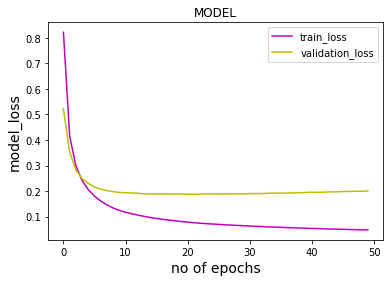

In [ ]:
import matplotlib.pyplot as plt 

plt.plot(history.history['loss'], c="m")
plt.plot(history.history['val_loss'], c="y")
plt.legend(["train_loss", "validation_loss"])
plt.title("MODEL")
plt.xlabel("no of epochs", fontsize=14)
plt.ylabel("model_loss", fontsize=14)
plt.show()

In [ ]:
# Encode input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)


In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [ ]:
# Saving encoder and decoder weights 

with open('encoder_model.json', 'w', encoding='utf8') as f:
    f.write(encoder_model.to_json())
encoder_model.save_weights('encoder_model_weights.h5')

with open('decoder_model.json', 'w', encoding='utf8') as f:
    f.write(decoder_model.to_json())
decoder_model.save_weights('decoder_model_weights.h5')

# Saving the model 
model.save("model.h5py")
model.save("model.h5")
! cp model.h5 drive/MyDrive/dataset/model.h5

In [ ]:
# ! mkdir drive/MyDrive/Dataset/newDir
! cp model.h5py drive/MyDrive/dataset/model.h5py
! cp model.h5 drive/MyDrive/dataset/model.h5
! cp decoder_model.json drive/MyDrive/dataset/decoder_model.json
! cp decoder_model_weights.h5 drive/MyDrive/dataset/decoder_model_weights.h5
! cp encoder_model.json drive/MyDrive/dataset/encoder_model.json
! cp encoder_model_weights.h5 drive/MyDrive/dataset/encoder_model_weights.h5

In [ ]:
test_gen = generate_batch(X_test, y_test, batch_size = 1)
k=-1


In [ ]:
while k<50:
    k+=1
    (input_seq, actual_output), _ = next(test_gen)
    decoded_sentence = decode_sequence(input_seq)
    print('input pseudocode:', X_test[k:k+1].values[0])
    print('actual c code:', y_test[k:k+1].values[0][6:-4])
    print('predicted c code:', decoded_sentence[:-4])
    print()

input pseudocode: set flag to 1
actual c code:  flag = 1  
predicted c code:  flag = 1 

input pseudocode: increment t
actual c code:  t++  
predicted c code:  t++ 

input pseudocode: g = "r"
actual c code:  g = "r"  
predicted c code:  g = "r" 

input pseudocode: if assistanttemps i > max or assistanttemps i < min
actual c code:  if assistanttemps i > max || assistanttemps i < min  
predicted c code:  if max > i || min if f2 i 

input pseudocode: declare long longs n, a
actual c code:  long long n, a  
predicted c code:  long long n, a 

input pseudocode: increment j
actual c code:  j++  
predicted c code:  j++ 

input pseudocode: print tot and newline
actual c code:  cout << tot << endl  
predicted c code:  cout << tot << endl 

input pseudocode: add a i to cnt1
actual c code:  cnt1 += a i  
predicted c code:  check += cnt1 i 

input pseudocode: create long integer a, maxx, z
actual c code:  long int a, maxx, z  
predicted c code:  long int a, x, maxx 

input pseudocode: read standar